In [ ]:
# ===== CELL 0: Mount Google Drive (SAFE) =====
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

print("TF:", tf.__version__)


TF: 2.19.0


In [ ]:
!ls "/content/drive/MyDrive/rsna_classification"


Classification		    final_outputs  outputs		    train_jpg
emergency_partial_model.h5  meta	   rsna-hemorrhage-jpg.zip


In [ ]:
BASE_DIR = "/content/drive/MyDrive/rsna_classification"

IMAGE_DIR = f"{BASE_DIR}/train_jpg/train_jpg"
LABEL_PATH = f"{BASE_DIR}/meta/meta/labels_cleaned.fth"
OUTPUT_DIR = f"{BASE_DIR}/final_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 3
LR = 1e-4
THRESHOLD = 0.3
CLASS_NAMES = [
    "epidural",
    "intraparenchymal",
    "intraventricular",
    "subarachnoid",
    "subdural",
    "any"
]

NUM_CLASSES = len(CLASS_NAMES)


In [ ]:
labels_df = pd.read_feather(LABEL_PATH)
labels_df = labels_df[["ID"] + CLASS_NAMES]

print("Labels:", len(labels_df))
labels_df.head()


Labels: 78257


,ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_00008ce3c,0,0,0,0,0,0
1,ID_0000aee4b,0,0,0,0,0,0
2,ID_0002003a8,0,0,0,0,0,0
3,ID_0002081b6,0,1,0,0,0,1
4,ID_00027cbb1,0,0,0,0,0,0


In [ ]:
# existing_files = set(
#     f.replace(".jpg", "")
#     for f in os.listdir(IMAGE_DIR)
#     if f.endswith(".jpg")
# )

# labels_df = labels_df[labels_df["ID"].isin(existing_files)].reset_index(drop=True)

# print("Usable samples:", len(labels_df))


In [ ]:
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.15,
    random_state=42,
    stratify=labels_df["any"]
)

print("Train:", len(train_df))
print("Val:", len(val_df))


Train: 66518
Val: 11739


In [ ]:
# ===== CELL 5.5: Robust balancing for hemorrhage detection =====

pos_df = train_df[train_df["any"] == 1]
neg_df = train_df[train_df["any"] == 0]

n_pos = len(pos_df)
n_neg = len(neg_df)

print("Before balancing:")
print("Pos (any=1):", n_pos)
print("Neg (any=0):", n_neg)

# Balance to the smaller class
n_samples = min(n_pos, n_neg)

pos_df = pos_df.sample(n_samples, random_state=42)
neg_df = neg_df.sample(n_samples, random_state=42)

train_df = (
    pd.concat([pos_df, neg_df])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("\nAfter balancing:")
print("Train size:", len(train_df))
print("Hemorrhage ratio (any):", train_df["any"].mean())


Before balancing:
Pos (any=1): 33394
Neg (any=0): 33124

After balancing:
Train size: 66248
Hemorrhage ratio (any): 0.5


In [ ]:
def load_image_tf(img_id, label):
    img_path = tf.strings.join([IMAGE_DIR, "/", img_id, ".jpg"])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)
    return img, label

def make_dataset(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["ID"].values, df[CLASS_NAMES].values.astype("float32"))
    )

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.map(load_image_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds = make_dataset(val_df, shuffle=False)

In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,384,169 (16.72 MB)

 Trainable params: 332,038 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
CHECKPOINT_PATH = f"{OUTPUT_DIR}/efficientnet_drive_best.h5"

checkpoint_cb = ModelCheckpoint(
    CHECKPOINT_PATH,
    monitor="val_recall",
    mode="max",
    save_best_only=True,
    verbose=1
)


safety_ckpt_path = f"{OUTPUT_DIR}/safety_backup.weights.h5"
safety_cb = ModelCheckpoint(
    safety_ckpt_path,
    save_weights_only=True,
    save_freq=100
)

early_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


In [ ]:
# Load safety checkpoint if it exists
if os.path.exists(safety_ckpt_path):
    print("Loading safety checkpoint...")
    model.load_weights(safety_ckpt_path)



Loading safety checkpoint...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     callbacks=[checkpoint_cb, safety_cb, early_cb]
# )

In [ ]:
val_ds_safe = val_ds.ignore_errors()


In [ ]:
model.evaluate(val_ds_safe)


    181/Unknown 5328s 29s/step - accuracy: 0.8618 - auc: 0.8826 - loss: 0.3196 - recall: 0.4805

KeyboardInterrupt: 

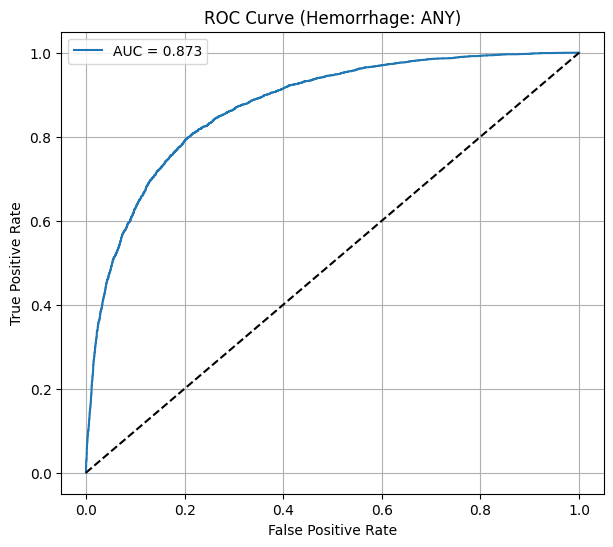

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_true = []
y_pred = []

# Collect predictions (limit for speed)
for imgs, labels in val_ds.take(200):   # 200 batches is enough
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels[:, -1].numpy())   # "any" label
    y_pred.extend(preds[:, -1])            # "any" prediction

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Hemorrhage: ANY)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

CLASS_NAMES = [
    "epidural",
    "intraparenchymal",
    "intraventricular",
    "subarachnoid",
    "subdural",
    "any"
]

y_true = {cls: [] for cls in CLASS_NAMES}
y_pred = {cls: [] for cls in CLASS_NAMES}

# ---- LIMIT BATCHES FOR SAFETY ----
MAX_BATCHES = 30   # you can reduce to 15 if needed
batch_count = 0

for imgs, labels in val_ds.take(MAX_BATCHES):
    preds = model.predict(imgs, verbose=0)

    for i, cls in enumerate(CLASS_NAMES):
        y_true[cls].extend(labels[:, i].numpy())
        y_pred[cls].extend(preds[:, i])

    batch_count += 1

print(f"Computed ROC-AUC on {batch_count} validation batches\n")

# ---- COMPUTE ROC-AUC PER CLASS ----
for cls in CLASS_NAMES:
    yt = np.array(y_true[cls])
    yp = np.array(y_pred[cls])

    # ROC-AUC requires at least one positive and one negative
    if len(np.unique(yt)) < 2:
        print(f"{cls:20s}: NOT COMPUTABLE (only one class present)")
    else:
        auc_val = roc_auc_score(yt, yp)
        print(f"{cls:20s}: ROC-AUC = {auc_val:.3f}")


Computed ROC-AUC on 30 validation batches

epidural            : ROC-AUC = 0.752
intraparenchymal    : ROC-AUC = 0.820
intraventricular    : ROC-AUC = 0.894
subarachnoid        : ROC-AUC = 0.749
subdural            : ROC-AUC = 0.812
any                 : ROC-AUC = 0.867


In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/rsna_classification/emergency_partial_model.h5",
    compile=False
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy")
    ]
)

model.evaluate(val_ds)


In [ ]:
model = tf.keras.models.load_model(CHECKPOINT_PATH, compile=False)
print("Best model loaded.")


In [ ]:
y_true, y_pred = [], []

for imgs, labels in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

roc_auc = roc_auc_score(y_true, y_pred, average="macro")
acc = accuracy_score(y_true[:, -1] >= 0.5, y_pred[:, -1] >= 0.5)
recall = recall_score(y_true[:, -1], y_pred[:, -1] >= 0.5)

print("ROC-AUC:", round(roc_auc, 4))
print("Accuracy (any):", round(acc, 4))
print("Recall (any):", round(recall, 4))
